## OHP He estimation from temperature measurements-two Hes

In [79]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [80]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations

In [81]:
cd(dirname(pwd()))
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing


Base.IOError: IOError: chdir src: no such file or directory (ENOENT)

## Initialization

In [82]:
    ω0 = [sqrt(1.2e004)];
    ℘ = [1.2e005];


    Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;


    γ = 1.3;#not 1.4!!!!! maybe 1.33?

In [83]:
    L = 4.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    alpha = pi/2 # inclination angle 

1.5707963267948966

In [84]:
tube = Tube(L,L2D,alpha)

Tube(4.0, 2.0, 1.5707963267948966)

In [85]:
Xe = map(tuple, [0.0; 3.0], [1.0; 4.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)])

In [86]:
Xc = map(tuple, [1.0], [3.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)])

In [87]:
X0 = [(1.5,3.5)]
dXdt0 = [(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)])

In [88]:
P = [1.0,1.0]

vapors=VaporPlug(γ,P)

VaporPlug(1.3, [1.0, 1.0])

In [89]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(4.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)]), LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)]), VaporPlug(1.3, [1.0, 1.0]))

## Get numerical solution

In [90]:
Lvaporplug = XptoLvaporplug(X0,L)
M = P.^(1/γ).* Lvaporplug

u=vcat(XMtovec(sys0.liquidslug.Xp,sys0.liquidslug.dXdt,M), He...)

7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

## Heaviside function

In [91]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))

heaviside (generic function with 1 method)

## EnKF PropagationFunction

In [92]:
function zhang2002modelEnKFtruth!(du::Array{Float64,1},uEnKF::Array{Float64,1},p::PHPSystem,t::Float64)

    sys = p

    # added He as a state vector entry
    u = uEnKF[1:end-1]
    uHe = deepcopy(uEnKF[end]) + 9*deepcopy(uEnKF[end])*heaviside.(t-tspan[end]/2)
#     uHe = deepcopy(uEnKF[end]) + 1*deepcopy(uEnKF[end])*t/tspan[end]-

    numofliquidslug =  Integer( (length(u) - 1)/5 )
    
    (Xp,dXdt0,M)=vectoXM(u)

    γ = sys.liquidslug.γ
    ω0 = sys.liquidslug.ω0
    ℘ = sys.liquidslug.℘
    Lvaporplug = XptoLvaporplug(Xp,sys.tube.L)
#     Lliquidslug = XptoLliquidslug(Xp)
    height = getheight(Xp,sys.tube.L2D,sys.tube.alpha)
    Xpvapor = getXpvapor(Xp,sys.tube.L)


    P = real.((M./Lvaporplug .+ 0im).^(γ))

    θ = real.((P .+ 0im).^((γ-1)/γ))


    for i = 1:numofliquidslug
        du[2*i-1] = u[2*numofliquidslug+2*i-1]
        du[2*i] = du[2*i-1]

        du[2*numofliquidslug + 2*i-1] = -32*u[2*numofliquidslug + 2*i-1] - (ω0[i]^2)*(0.5*(height[i][end]-height[i][1])) + ℘[i]*(P[i]-P[i+1])
        du[2*numofliquidslug + 2*i] = du[2*numofliquidslug + 2*i-1]

    end


        du[4*numofliquidslug+1:5*numofliquidslug+1] .= dMdtzhang2002modelEnKF(Xpvapor,θ,sys,uHe)
    
    du[end]=0.0

    return du

end

zhang2002modelEnKFtruth! (generic function with 1 method)

In [93]:
function zhang2002modelEnKF!(du::Array{Float64,1},uEnKF::Array{Float64,1},p::PHPSystem,t::Float64)

    sys = p

    # added He as a state vector entry
    u = uEnKF[1:end-1]
    uHe = deepcopy(uEnKF[end])

    numofliquidslug =  Integer( (length(u) - 1)/5 )
    
    (Xp,dXdt0,M)=vectoXM(u)

    γ = sys.liquidslug.γ
    ω0 = sys.liquidslug.ω0
    ℘ = sys.liquidslug.℘
    Lvaporplug = XptoLvaporplug(Xp,sys.tube.L)
#     Lliquidslug = XptoLliquidslug(Xp)
    height = getheight(Xp,sys.tube.L2D,sys.tube.alpha)
    Xpvapor = getXpvapor(Xp,sys.tube.L)


    P = real.((M./Lvaporplug .+ 0im).^(γ))

    θ = real.((P .+ 0im).^((γ-1)/γ))


    for i = 1:numofliquidslug
        du[2*i-1] = u[2*numofliquidslug+2*i-1]
        du[2*i] = du[2*i-1]

        du[2*numofliquidslug + 2*i-1] = -32*u[2*numofliquidslug + 2*i-1] - (ω0[i]^2)*(0.5*(height[i][end]-height[i][1])) + ℘[i]*(P[i]-P[i+1])
        du[2*numofliquidslug + 2*i] = du[2*numofliquidslug + 2*i-1]

    end


        du[4*numofliquidslug+1:5*numofliquidslug+1] .= dMdtzhang2002modelEnKF(Xpvapor,θ,sys,uHe)
    
    du[end]=0.0

    return du

end


function dMdtzhang2002modelEnKF(Xpvapor::Array{Tuple{Float64,Float64},1},θ::Array{Float64,1},sys::PHPSystem,uHe)

    dMdt=zeros(length(Xpvapor))


    Xe = sys.evaporator.Xe
    He = uHe
    θe = sys.evaporator.θe

    Xc = sys.condenser.Xc
    Hc = sys.condenser.Hc
    θc = sys.condenser.θc

    Levapoverlap=XpvaportoLoverlap(Xpvapor,Xe)
    Lcondoverlap=XpvaportoLoverlap(Xpvapor,Xc)


    # May not be right for multi liquid flow
    for i = 1:length(Xpvapor)
        if Lcondoverlap[i] < 1e-8
            dMdt[i] = He * Levapoverlap[i] * (θe-θ[i])
        else
            dMdt[i] = -Hc * Lcondoverlap[i] * (θ[i]-θc)
        end
    end

    return dMdt

end

dMdtzhang2002modelEnKF (generic function with 1 method)

In [94]:
tstep=1.0e-5

p = sys0
tspan = (0.0, 0.1);
T = tspan[1]:tstep:tspan[end]

prob = ODEProblem(zhang2002modelEnKFtruth!, u, tspan, p)
sol = solve(prob, RK4(), adaptive=false, dt=tstep);
integrator = init(prob, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

## EnKF

In [95]:
probEnKF = ODEProblem(zhang2002modelEnKF!, u, tspan, p)
solEnKF = solve(probEnKF, RK4(), adaptive=false, dt=tstep);
integrator = init(probEnKF, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

In [96]:
newHe = 0.0

0.0

In [97]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
#         for j=1:10
        step!(integrator)
#         end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [98]:
fprop = PropagationFunction()

PropagationFunction()

In [99]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    result=soltoResult(s[1:end-1],sys0);
#     return [s[3]]
    return [deepcopy(result.θ[1]),deepcopy(result.θ[2])]
end

In [100]:
function (::MeasurementFunction)(t::Float64) 
#     return reshape([0.0, 0.0, 1.0, 0.0, 0.0, 0.0],(1,6))
    return reshape([1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0,0.0],(2,7))
end

In [101]:
m = MeasurementFunction()

MeasurementFunction()

In [102]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
#     fill!(ENS, [deepcopy(s[3])])
        result=soltoResult(s[1:end-1],sys0);
    fill!(ENS, [deepcopy(result.θ[1]),deepcopy(result.θ[2])])
    end
    return ENS
end

In [103]:
z = RealMeasurementFunction()

RealMeasurementFunction()

In [104]:
# A = MultiAdditiveInflation(2, 1.05, MvNormal(zeros(1), 2.0*I))
A = MultiAdditiveInflation(7, 1.001, MvNormal(zeros(7), 0.00001*Diagonal([1.0,1.0,100000.0,100000.0,1.0,1.0,1000000000000.0])))
# A = IdentityInflation()

MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-5 0.0 … 0.0 0.0; 0.0 1.0e-5 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-5 0.0; 0.0 0.0 … 0.0 1.0e7]
)
)

In [105]:
# this is measurement noise!!!!!!!!
# ϵ = AdditiveInflation(MvNormal(zeros(1), 1.0*I))
ϵ = AdditiveInflation(MvNormal(zeros(2), 0.00001*I))

AdditiveInflation{2}(IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0e-5 0.0; 0.0 1.0e-5]
)
)

In [106]:
N = 50
# NZ = 1
NZ = 2
isinflated = true
isfiltered = false
isaugmented = true

true

In [107]:
x₀ = [1.0, 3.0, 0.0, 0.0, 1.0, 1.0, newHe]
ens = initialize(N, MvNormal(x₀, 1^2*Diagonal([1.0,1.0,100.0,100.0,1.0,1.0,1000.0].^2)))
estimation_state = [deepcopy(ens.S)]

true_state = [deepcopy(x₀)]
covs = []

0-element Array{Any,1}

In [108]:
g = FilteringFunction()

FilteringFunction()

In [109]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{50,2}(PropagationFunction(), MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-5 0.0 … 0.0 0.0; 0.0 1.0e-5 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-5 0.0; 0.0 0.0 … 0.0 1.0e7]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{2}(IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0e-5 0.0; 0.0 1.0e-5]
)
), true, false, true)

In [110]:
Δt = 1e-5
Tsub = 0.0:Δt:0.1-Δt

for (n,t) in enumerate(Tsub)

    global ens
    
    t, ens, cov = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    push!(covs, deepcopy(cov))
    

end

## Show the results

In [111]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)
# ŝ =  hcat(solEnKF(T).u...)

results=soltoResult(sol[1:end-1,:],sys0);
resultŝ=soltoResult(ŝ[1:end-1,:],sys0);
# resultŝ=soltoResult(solEnKF[1:end-1,:],sys0);



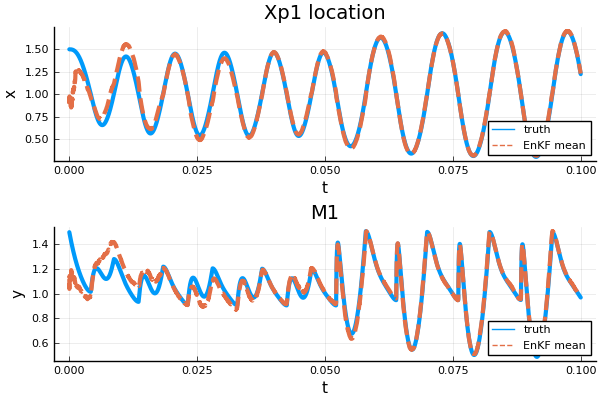

In [112]:
plt1 = plot(layout = (2, 1), legend = :bottomright)
plot!(plt1[1], T, results.Xp[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt1[1], Tsub, resultŝ.Xp[1][1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash,title="Xp1 location")

plot!(plt1[2], T, results.M[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt1[2], Tsub, resultŝ.M[1][1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash,title="M1")

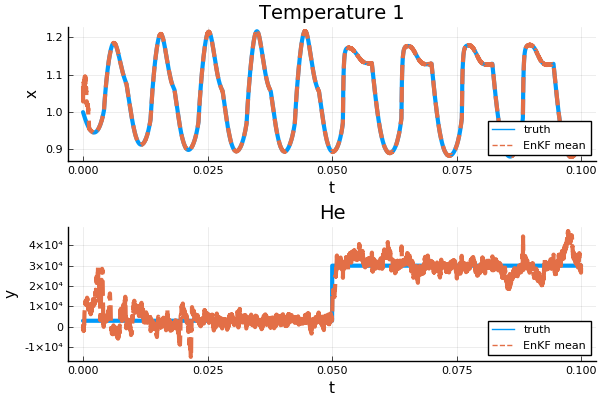

In [113]:
plt2 = plot(layout = (2, 1), legend = :bottomright)

plot!(plt2[1], T, results.θ[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt2[1], Tsub, resultŝ.θ[1][1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash,title="Temperature 1")

plot!(plt2[2], T, (sol[end,1:end-1] + 9*sol[end,1:end-1].*heaviside.(T .- tspan[end]/2)), linewidth = 3, label = "truth")
plot!(plt2[2], Tsub, ŝ[7,1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash,title="He")

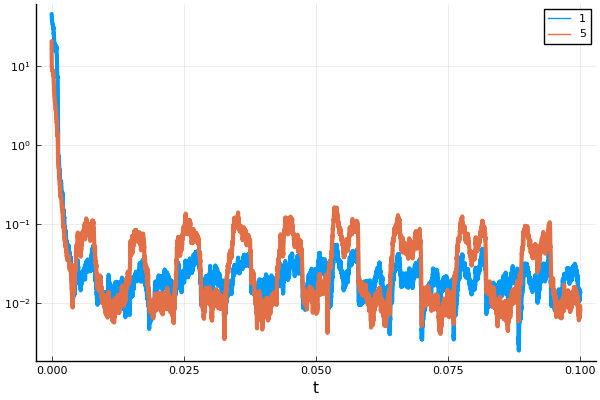

In [114]:
plot(Tsub, map(covs) do P  
        P[1,1]+ eps() end, yscale = :log10, linewidth = 3, label = "1")
plot!(Tsub, map(covs) do P
        P[5,5]+ eps() end, yscale = :log10, linewidth = 3, xlabel = "t", label = "5")

In [115]:
ens.S

50-element Array{Array{Float64,1},1}:
 [1.2030890881395824, 3.2138621264746767, -343.0108508637876, -440.6077849979083, 0.9588727316588624, 1.167056396119066, 35517.94251832362]   
 [1.2242364688388407, 3.1902500091075185, -355.31241969767024, -440.18946421674735, 0.9724733599703543, 1.1959560477380007, 40456.54698004643]
 [1.2036537728017818, 3.2373652821807886, -339.6035187346015, -441.39986016294756, 0.9567979601893175, 1.1394907842061093, 31034.80835624008] 
 [1.248526854215337, 3.275849042170769, -344.70447978569763, -431.0348535736267, 0.9973756309570284, 1.0859576781072897, 10928.030759253694]  
 [1.2647373119093086, 3.2369317643296998, -336.5198337967903, -433.6298315990397, 0.9975585782546986, 1.1424099472125584, 26009.43800728317]  
 [1.2288445212474368, 3.2108615801889404, -347.16112422240906, -428.7163092910093, 0.9702586188795969, 1.1834713553317484, 32107.159937333363]
 [1.2133391857789368, 3.2120188524168998, -356.96513334078475, -437.4524594428263, 0.9522337876103751, 1

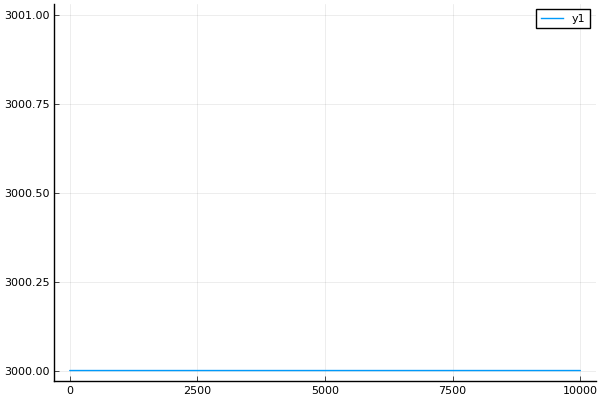

In [116]:
plot(sol[7,:])

In [117]:
ens = initialize(N, MvNormal(x₀, 0.1*Diagonal([1.0,1.0,100000.0,100000.0,1.0,1.0,100000000.0])))
ens.S

50-element Array{Array{Float64,1},1}:
 [0.7922080781611529, 3.0914623989163346, 126.41332439933373, 0.3480704451380124, 0.5273797866140681, 1.0283376349213322, -1020.917169084916]  
 [0.7999751290080546, 3.2225823248684993, -11.128543833831705, -46.76733765578977, 1.3080829982199536, 1.0858392464367252, 814.7067313487157]  
 [1.2025975437002947, 2.5532232204885172, 84.76652263113525, 84.96110970475394, 0.8366194842262149, 0.7928525786977079, -1286.6811458125446]   
 [0.9115066293880969, 2.7410427917954308, -70.29698065121754, 105.34255640353093, 0.9511517770534662, 1.0136836997208016, 3898.860455812076]   
 [0.8936068948674767, 3.1697776022652064, 39.92466589929889, 37.5889549196274, 1.2397983531688184, 0.96891678494199, -5025.166349830171]       
 [1.4870868951632707, 2.9972586272418025, -41.05301975920565, -12.637991061447378, 1.2377446764730546, 1.0312384513702046, -3364.9263319190663]
 [0.9370584282532279, 2.476432942065378, -77.23122807158333, 193.6489915242863, 0.3687340665731812